<a href="https://colab.research.google.com/github/TanmoyGG/Mini_SciBERT-Pre-training-Fine-tuning-BERT-for-Scientific-NER-and-Classification/blob/main/mini_scibert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-SciBERT: Pre-training and Fine-tuning BERT for Scientific Text

## Project Overview
This notebook implements a complete end-to-end pipeline for creating a domain-adapted BERT model specifically optimized for scientific literature understanding. Mini-SciBERT demonstrates how continued pre-training on domain-specific corpora can significantly improve model performance on specialized downstream tasks.

## Key Components

### 1. Data Preparation & Corpus Construction
- **Corpus Composition**: Combines 20,000 documents with an 82% biomedical (PubMed) and 18% general scientific papers ratio
- **Dual-Task Dataset Creation**: Generates 200,000 sentence pairs for Next Sentence Prediction (NSP) with balanced positive/negative examples
- **Sentence Tokenization**: Extracts and processes individual sentences from research papers using NLTK

### 2. Pre-training Phase
- **Architecture**: BERT-base-cased (110M parameters) with custom data collators
- **Training Objectives**:
  - Masked Language Modeling (MLM) with 15% masking probability
  - Next Sentence Prediction (NSP) for understanding document structure
- **Hyperparameters**: 2 epochs, batch size 8, learning rate 3e-5, max sequence length 256
- **Infrastructure**: W&B experiment tracking, gradient accumulation, mixed-precision training (FP16)

### 3. Fine-tuning & Evaluation
- **Task 1 - Named Entity Recognition (BC5CDR)**: Identifies chemical and disease entities in biomedical text
- **Task 2 - Citation Intent Classification (SciCite)**: Classifies citation contexts into background, method, or result categories
- **Baseline Comparison**: Evaluates Mini-SciBERT against vanilla BERT-base-cased to measure domain adaptation impact
- **Metrics**: F1-score for NER, accuracy for classification

### 4. Results & Visualization
- Performance comparison across both tasks
- Statistical analysis of improvement gains
- Visual charts demonstrating Mini-SciBERT's advantages on scientific domain tasks

## Technologies Used
Hugging Face Transformers, PyTorch, Weights & Biases, NLTK, Datasets, Matplotlib

# Configuration and Hyperparameters
Define all configuration variables and hyperparameters for pre-training and fine-tuning.

In [ ]:
SAMPLE_DOCS = 20000
MAX_PRETRAIN_EXAMPLES = 200000
MLM_PROB = 0.15


PRETRAIN_EPOCHS = 2
PRETRAIN_BATCH_SIZE = 8
PRETRAIN_MAXLEN = 256
PRETRAIN_LEARNING_RATE = 3e-5

PRETRAIN_SAVE_DIR = "/kaggle/working/miniscibert_pretrained"

FT_EPOCHS = 5
FT_BATCH_SIZE = 32
FT_LEARNING_RATE = 2e-5


print("--- PROJECT CONFIGURATION ---")
print("\n[General Settings]")
print(f"{'Pre-training Corpus Size:':<25} {SAMPLE_DOCS} documents")
print(f"{'Max Pre-training Pairs:':<25} {MAX_PRETRAIN_EXAMPLES} examples")

print("\n[Pre-training Hyperparameters]")
print(f"{'Epochs:':<25} {PRETRAIN_EPOCHS}")
print(f"{'Batch Size (per device):':<25} {PRETRAIN_BATCH_SIZE}")
print(f"{'Max Sequence Length:':<25} {PRETRAIN_MAXLEN}")
print(f"{'Learning Rate:':<25} {PRETRAIN_LEARNING_RATE}")
print(f"{'Save Directory:':<25} {PRETRAIN_SAVE_DIR}")

print("\n[Fine-tuning Hyperparameters]")
print(f"{'Epochs:':<25} {FT_EPOCHS}")
print(f"{'Batch Size:':<25} {FT_BATCH_SIZE}")
print(f"{'Learning Rate:':<25} {FT_LEARNING_RATE}")
print("-" * 29)


--- PROJECT CONFIGURATION ---

[General Settings]
Pre-training Corpus Size: 20000 documents
Max Pre-training Pairs:   200000 examples

[Pre-training Hyperparameters]
Epochs:                   2
Batch Size (per device):  8
Max Sequence Length:      256
Learning Rate:            3e-05
Save Directory:           /kaggle/working/miniscibert_pretrained

[Fine-tuning Hyperparameters]
Epochs:                   5
Batch Size:               32
Learning Rate:            2e-05
-----------------------------


# Environment Setup and Library Installation
Install required libraries, import dependencies, configure W&B, and verify PyTorch/CUDA availability.

In [ ]:

!pip install -q transformers datasets accelerate sentencepiece sacremoses evaluate seqeval nltk
import os, random, math, json, time
import numpy as np
import torch
import wandb
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer, AutoConfig, BertForPreTraining, BertForTokenClassification,
    BertForSequenceClassification, Trainer, TrainingArguments,
)

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

os.environ["WANDB_API_KEY"] = secret_value_0


from transformers import DataCollatorForLanguageModeling
from transformers.trainer_pt_utils import get_parameter_names
from transformers.utils import check_min_version
from evaluate import load as load_metric


print("--- ENVIRONMENT SETUP COMPLETE ---")
print("✅ Libraries installed successfully.")
print("✅ NLTK tokenizers downloaded.")

if wandb.login(key=secret_value_0):
    print("✅ Successfully logged into Weights & Biases.")
else:
    print("⚠️  Could not log into Weights & Biases.")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ PyTorch Version: {torch.__version__}")
print(f"✅ Using device: {device.upper()}")
print("-" * 34)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 22.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 44.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

--- ENVIRONMENT SETUP COMPLETE ---
✅ Libraries installed successfully.
✅ NLTK tokenizers downloaded.


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tanmoydas180719 (tanmoydas180719-american-international-university-bangladesh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Successfully logged into Weights & Biases.
✅ PyTorch Version: 2.6.0+cu124
✅ Using device: CUDA
----------------------------------


# Load Pre-training Corpora
Load scientific paper datasets from Hugging Face for creating the pre-training corpus.

In [ ]:

CORPUS_NAME_1 = "NothingMuch/Semantic-Scholar-Papers"
print("Loading corpus 1:", CORPUS_NAME_1)
ds1 = load_dataset(CORPUS_NAME_1, split="train")
print(ds1)
print(f"Total records in corpus 1: {len(ds1)}")


CORPUS_NAME_2 = "marcov/scientific_papers_pubmed_promptsource"
print("\nLoading corpus 2:", CORPUS_NAME_2)
ds2 = load_dataset(CORPUS_NAME_2, split="test")
print(ds2)
print(f"Total records in corpus 2: {len(ds2)}")


Loading corpus 1: NothingMuch/Semantic-Scholar-Papers


README.md:   0%|          | 0.00/510 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/25.7M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20468 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5117 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'title', 'abstract', 'tldr'],
    num_rows: 20468
})
Total records in corpus 1: 20468

Loading corpus 2: marcov/scientific_papers_pubmed_promptsource


README.md:   0%|          | 0.00/765 [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

data/train-00000-of-00030.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

data/train-00001-of-00030.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

data/train-00002-of-00030.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

data/train-00003-of-00030.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

data/train-00004-of-00030.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

data/train-00005-of-00030.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00006-of-00030.parquet:   0%|          | 0.00/222M [00:00<?, ?B/s]

data/train-00007-of-00030.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

data/train-00008-of-00030.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

data/train-00009-of-00030.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00010-of-00030.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

data/train-00011-of-00030.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

data/train-00012-of-00030.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00013-of-00030.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

data/train-00014-of-00030.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

data/train-00015-of-00030.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

data/train-00016-of-00030.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

data/train-00017-of-00030.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

data/train-00018-of-00030.parquet:   0%|          | 0.00/238M [00:00<?, ?B/s]

data/train-00019-of-00030.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

data/train-00020-of-00030.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

data/train-00021-of-00030.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

data/train-00022-of-00030.parquet:   0%|          | 0.00/226M [00:00<?, ?B/s]

data/train-00023-of-00030.parquet:   0%|          | 0.00/230M [00:00<?, ?B/s]

data/train-00024-of-00030.parquet:   0%|          | 0.00/229M [00:00<?, ?B/s]

data/train-00025-of-00030.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

data/train-00026-of-00030.parquet:   0%|          | 0.00/240M [00:00<?, ?B/s]

data/train-00027-of-00030.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

data/train-00028-of-00030.parquet:   0%|          | 0.00/243M [00:00<?, ?B/s]

data/train-00029-of-00030.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

data/validation-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

data/validation-00001-of-00002.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

data/test-00000-of-00002.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

data/test-00001-of-00002.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/719544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/39798 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/39948 [00:00<?, ? examples/s]

Dataset({
    features: ['article', 'abstract', 'section_names', 'template_name', 'template', 'rendered_input', 'rendered_output'],
    num_rows: 39948
})
Total records in corpus 2: 39948


# Sample Documents from Corpora
Sample documents from both corpora with the specified biomedical and general science ratio.

In [ ]:
import random

biomedical_ratio = 0.82
general_ratio = 0.18


num_biomedical_samples = int(SAMPLE_DOCS * biomedical_ratio)
num_general_samples = SAMPLE_DOCS - num_biomedical_samples
print(f"Aiming for {num_general_samples} general and {num_biomedical_samples} biomedical samples...")


print(f"Sampling {num_general_samples} abstracts from corpus 1...")
docs1_full = [rec.get("abstract", "") for rec in ds1 if rec.get("abstract")]
random.shuffle(docs1_full)
docs1 = docs1_full[:num_general_samples]


print(f"Sampling {num_biomedical_samples} articles from corpus 2...")
docs2_full = [rec.get("article", "") for rec in ds2 if rec.get("article")]
random.shuffle(docs2_full)
docs2 = docs2_full[:num_biomedical_samples]


docs = docs1 + docs2
print(f"\nTotal combined documents: {len(docs1)} (general) + {len(docs2)} (biomedical) = {len(docs)}")


random.shuffle(docs)

print(f"Final sampled docs for pre-training: {len(docs)}")


Aiming for 3600 general and 16400 biomedical samples...
Sampling 3600 abstracts from corpus 1...
Sampling 16400 articles from corpus 2...

Total combined documents: 3600 (general) + 16400 (biomedical) = 20000
Final sampled docs for pre-training: 20000


# Create Next Sentence Prediction (NSP) Dataset
Generate positive and negative sentence pairs for the NSP pre-training task.

In [ ]:
from nltk.tokenize import sent_tokenize

sentences_by_doc = [sent_tokenize(d) for d in docs]

all_sentences = [s for doc in sentences_by_doc for s in doc if len(s.strip())>5]


pairs = []
for doc_sents in sentences_by_doc:
    for i in range(len(doc_sents)-1):
        s1 = doc_sents[i].strip()
        s2 = doc_sents[i+1].strip()
        if len(s1)>3 and len(s2)>3:
            pairs.append({"sent1": s1, "sent2": s2, "is_next": 1})

num_pos = len(pairs)
num_neg = num_pos
for _ in range(num_neg):
    s1 = random.choice(all_sentences)
    s2 = random.choice(all_sentences)
    if s1!=s2:
        pairs.append({"sent1": s1, "sent2": s2, "is_next": 0})


random.shuffle(pairs)
pairs = pairs[:MAX_PRETRAIN_EXAMPLES]


print("\n--- NSP DATASET CREATION COMPLETE ---")
print(f" Extracted {len(all_sentences):,} total sentences from the corpus.")
print(f" Created {num_pos:,} positive sentence pairs (IsNext=True).")
print(f" Created {num_neg:,} negative sentence pairs (IsNext=False).")
print(f" Final pre-training dataset contains {len(pairs):,} shuffled pairs.")
print("-" * 37)



--- NSP DATASET CREATION COMPLETE ---
 Extracted 1,709,452 total sentences from the corpus.
 Created 1,687,611 positive sentence pairs (IsNext=True).
 Created 1,687,611 negative sentence pairs (IsNext=False).
 Final pre-training dataset contains 200,000 shuffled pairs.
-------------------------------------


# Initialize Tokenizer and Dataset
Load the BERT tokenizer and convert sentence pairs into a Hugging Face Dataset.

In [ ]:
from transformers import AutoTokenizer

PRETRAIN_MODEL_NAME = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(PRETRAIN_MODEL_NAME, use_fast=True)
tokenizer.model_max_length = PRETRAIN_MAXLEN


print("Tokenizer vocab size:", tokenizer.vocab_size)
print("Sample tokenization:", tokenizer(pairs[0]['sent1'], pairs[0]['sent2'])['input_ids'][:20])


pairs_ds = Dataset.from_list(pairs)


print("\n--- TOKENIZER & DATASET PREPARATION COMPLETE ---")
print(f" Tokenizer loaded for model: '{PRETRAIN_MODEL_NAME}'")
print(f"   - Vocabulary Size: {tokenizer.vocab_size}")
print(f"   - Max Length Set To: {tokenizer.model_max_length}")
print(f" Successfully converted {len(pairs_ds)} sentence pairs into a Hugging Face Dataset.")
print("-" * 44)


Tokenizer vocab size: 28996
Sample tokenization: [101, 15961, 2593, 27053, 1114, 7234, 1116, 1107, 24928, 3818, 12736, 20473, 118, 1106, 118, 181, 25698, 13335, 14300, 24576]

--- TOKENIZER & DATASET PREPARATION COMPLETE ---
 Tokenizer loaded for model: 'bert-base-cased'
   - Vocabulary Size: 28996
   - Max Length Set To: 256
 Successfully converted 200000 sentence pairs into a Hugging Face Dataset.
--------------------------------------------


# Tokenize Pre-training Dataset
Apply tokenization to all sentence pairs with padding and truncation for model input.

In [ ]:
def tokenize_for_pretrain(batch):

    tokenized = tokenizer(batch['sent1'], batch['sent2'],
                          truncation=True, max_length=PRETRAIN_MAXLEN, padding="max_length")
    tokenized["next_sentence_label"] = batch["is_next"]
    return tokenized

tokenized_pairs = pairs_ds.map(tokenize_for_pretrain, batched=True, remove_columns=pairs_ds.column_names)


print("\n--- DATASET TOKENIZATION COMPLETE ---")
print(f" Successfully tokenized {len(tokenized_pairs):,} sentence pairs.")
print("The dataset is now in a model-ready format with the following features:")

for feature in tokenized_pairs.features:
    print(f"   - {feature}")
print("-" * 35)


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]


--- DATASET TOKENIZATION COMPLETE ---
 Successfully tokenized 200,000 sentence pairs.
The dataset is now in a model-ready format with the following features:
   - input_ids
   - token_type_ids
   - attention_mask
   - next_sentence_label
-----------------------------------


# Create Custom Data Collator for MLM and NSP
Implement a data collator that handles both Masked Language Modeling and Next Sentence Prediction tasks.

In [ ]:
import torch
from transformers import default_data_collator
from copy import deepcopy

class DataCollatorForMLMandNSP:
    def __init__(self, tokenizer, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.mlm_prob = mlm_probability
        self.mask_token_id = tokenizer.mask_token_id
        self.vocab_size = tokenizer.vocab_size
        self.special_ids = set(tokenizer.all_special_ids)

    def mask_tokens(self, inputs: torch.Tensor):
        """
        Prepare masked tokens inputs/labels for MLM as in BERT:
        80% -> [MASK], 10% -> random, 10% -> original.
        """
        labels = inputs.clone()

        probability_matrix = torch.full(labels.shape, self.mlm_prob)
        special_tokens_mask = [
            self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
        ]
        special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
        probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
        masked_indices = torch.bernoulli(probability_matrix).bool()
        labels[~masked_indices] = -100


        indices_replaced = (torch.bernoulli(torch.full(labels.shape, 0.8)).bool()) & masked_indices
        inputs[indices_replaced] = self.mask_token_id


        indices_random = (torch.bernoulli(torch.full(labels.shape, 0.5)).bool()) & masked_indices & ~indices_replaced

        random_words = torch.randint(low=0, high=self.vocab_size, size=labels.shape, dtype=torch.long)
        inputs[indices_random] = random_words[indices_random]


        return inputs, labels

    def __call__(self, features):

        batch = {k: torch.tensor([f[k] for f in features]) for k in features[0].keys() if k!="next_sentence_label"}
        next_sentence_labels = torch.tensor([f["next_sentence_label"] for f in features], dtype=torch.long)
        input_ids = batch["input_ids"].clone()
        input_ids, labels = self.mask_tokens(input_ids)
        batch["input_ids"] = input_ids
        batch["labels"] = labels
        batch["next_sentence_label"] = next_sentence_labels
        return batch

collator = DataCollatorForMLMandNSP(tokenizer, mlm_probability=MLM_PROB)


print("\n--- CUSTOM DATA COLLATOR READY ---")
print(" Successfully initialized the DataCollatorForMLM and NSP.")
print(f"   - It will dynamically mask tokens with a {MLM_PROB*100:.0f}% probability for MLM.")
print("   - It will also correctly format the labels for the NSP task.")
print("-" * 34)



--- CUSTOM DATA COLLATOR READY ---
 Successfully initialized the DataCollatorForMLM and NSP.
   - It will dynamically mask tokens with a 15% probability for MLM.
   - It will also correctly format the labels for the NSP task.
----------------------------------


# Initialize Pre-training Model and Trainer
Load BERT model for pre-training and configure the Hugging Face Trainer with training arguments.

In [ ]:
from transformers import BertForPreTraining

model = BertForPreTraining.from_pretrained(PRETRAIN_MODEL_NAME)


pretrain_args = TrainingArguments(
    output_dir=PRETRAIN_SAVE_DIR,
    overwrite_output_dir=True,
    num_train_epochs=PRETRAIN_EPOCHS,
    per_device_train_batch_size=PRETRAIN_BATCH_SIZE,
    learning_rate=PRETRAIN_LEARNING_RATE,
    weight_decay=0.01,
    fp16=True if device=="cuda" else False,
    save_steps=2000,
    save_total_limit=3,
    logging_steps=100,
    max_steps=-1,
    remove_unused_columns=False,
    gradient_accumulation_steps=2,
    report_to="wandb",
    run_name="MiciSciBERT",
    ddp_find_unused_parameters=False,
    dataloader_num_workers=2,
    max_grad_norm=1.0
)

trainer = Trainer(
    model=model,
    args=pretrain_args,
    train_dataset=tokenized_pairs,
    data_collator=collator,
)

effective_batch_size = (
    pretrain_args.per_device_train_batch_size
    * pretrain_args.gradient_accumulation_steps
    * pretrain_args.world_size
)

print("Ready to pretrain. Dataset length:", len(tokenized_pairs))

print("\n--- PRE-TRAINING TRAINER INITIALIZED ---")
print(f" Trainer is ready for pre-training.")
print(f"   - Model:                {model.config.model_type}")
print(f"   - Dataset size:           {len(tokenized_pairs):,} examples")
print(f"   - Epochs:                 {pretrain_args.num_train_epochs}")
print(f"   - Batch size per GPU:     {pretrain_args.per_device_train_batch_size}")
print(f"   - Effective batch size:   {effective_batch_size} (with accumulation & multi-GPU)")
print(f"   - Logging to W&B run:     '{pretrain_args.run_name}'")
print("-" * 40)


Ready to pretrain. Dataset length: 200000

--- PRE-TRAINING TRAINER INITIALIZED ---
 Trainer is ready for pre-training.
   - Model:                bert
   - Dataset size:           200,000 examples
   - Epochs:                 2
   - Batch size per GPU:     8
   - Effective batch size:   16 (with accumulation & multi-GPU)
   - Logging to W&B run:     'MiciSciBERT'
----------------------------------------


# Execute Pre-training
Run the pre-training process and save the model checkpoint to disk and W&B Artifacts.

In [ ]:
print("Starting pre-training...")
trainer.train()
print("Pre-training finished.")

if trainer.is_world_process_zero():
    print("Saving model and tokenizer on main process...")
    trainer.save_model(PRETRAIN_SAVE_DIR)
    tokenizer.save_pretrained(PRETRAIN_SAVE_DIR)
    print("Pre-training complete. Model and tokenizer saved locally to:", PRETRAIN_SAVE_DIR)


    print("Logging final model to W&B Artifacts...")
    model_artifact = wandb.Artifact(
        name="model-MiniSciBERT",
        type="model"
    )
    model_artifact.add_dir(PRETRAIN_SAVE_DIR)
    wandb.log_artifact(model_artifact)
    print("✅ Successfully logged artifact to W&B.")


Starting pre-training...


wandb: Currently logged in as: tanmoydas180719 (tanmoydas180719-american-international-university-bangladesh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,3.238000
200,2.756000
300,2.601400
400,2.595300
500,2.580200
600,2.538500
700,2.502200
800,2.460800
900,2.483300
1000,2.450500


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
h

Pre-training finished.
Saving model and tokenizer on main process...
Pre-training complete. Model and tokenizer saved locally to: /kaggle/working/miniscibert_pretrained
Logging final model to W&B Artifacts...


wandb: Adding directory to artifact (/kaggle/working/miniscibert_pretrained)... Done. 28.5s


✅ Successfully logged artifact to W&B.


# Set Pretrained Model Path
Determine the path to the pretrained model for downstream fine-tuning tasks.

In [ ]:
pretrained_path = PRETRAIN_SAVE_DIR if os.path.exists(PRETRAIN_SAVE_DIR) else PRETRAIN_MODEL_NAME
print("Will use pretrained model from:", pretrained_path)


Will use pretrained model from: /kaggle/working/miniscibert_pretrained


# Load Pretrained Model from W&B Artifacts
Download the pretrained Mini-SciBERT model from Weights & Biases Artifacts.

In [ ]:
import wandb, os, requests
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
import numpy as np
from evaluate import load as load_metric

wandb.init(project="huggingface", job_type="load-artifact")

artifact = wandb.use_artifact(
    "tanmoydas180719-american-international-university-bangladesh/huggingface/model-MiniSciBERT:latest",
    type="model"
)
artifact_dir = artifact.download("/kaggle/working/miniscibert_pretrained")

pretrained_path = artifact_dir
print("✅ Restored pretrained model at:", pretrained_path)


wandb: Downloading large artifact model-MiniSciBERT:latest, 4159.54MB. 43 files... 
wandb:   43 of 43 files downloaded.  
Done. 0:0:34.6 (120.3MB/s)


✅ Restored pretrained model at: /kaggle/working/miniscibert_pretrained


# Fine-tune on BC5CDR NER Task
Download BC5CDR dataset, prepare it for Named Entity Recognition, and fine-tune both baseline and Mini-SciBERT models.

Models to evaluate: {'BERT_BASELINE': 'bert-base-cased', 'MINI_SCIBERT': '/kaggle/working/miniscibert_pretrained'}


Map:   0%|          | 0/3942 [00:00<?, ? examples/s]

Map:   0%|          | 0/3949 [00:00<?, ? examples/s]

Map:   0%|          | 0/4139 [00:00<?, ? examples/s]

BC5CDR dataset: DatasetDict({
    train: Dataset({
        features: ['words', 'ner_tags', 'labels'],
        num_rows: 3942
    })
    validation: Dataset({
        features: ['words', 'ner_tags', 'labels'],
        num_rows: 3949
    })
    test: Dataset({
        features: ['words', 'ner_tags', 'labels'],
        num_rows: 4139
    })
})

==== Fine-tuning NER model on BC5CDR: BERT_BASELINE ====


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3942 [00:00<?, ? examples/s]

Map:   0%|          | 0/3949 [00:00<?, ? examples/s]

/tmp/ipykernel_37/3322968928.py:155: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.284400,0.135203,0.771810,0.837972,0.803532
2,0.123100,0.111767,0.803233,0.862313,0.831726
3,0.085000,0.108539,0.815743,0.871944,0.842908
4,0.064200,0.111274,0.825896,0.873532,0.849046
5,0.042700,0.115242,0.822913,0.871944,0.846719


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

BERT_BASELINE BC5CDR NER eval: {'eval_loss': 0.10853875428438187, 'eval_precision': 0.8157425742574257, 'eval_recall': 0.8719441210710128, 'eval_f1': 0.8429075656043787, 'eval_runtime': 18.6245, 'eval_samples_per_second': 212.032, 'eval_steps_per_second': 3.329, 'epoch': 5.0}


wandb: Adding directory to artifact (/kaggle/working/BERT_BASELINE_bc5cdr_ner)... Done. 16.2s
Some weights of BertForTokenClassification were not initialized from the model checkpoint at /kaggle/working/miniscibert_pretrained and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==== Fine-tuning NER model on BC5CDR: MINI_SCIBERT ====


Map:   0%|          | 0/3942 [00:00<?, ? examples/s]

Map:   0%|          | 0/3949 [00:00<?, ? examples/s]

/tmp/ipykernel_37/3322968928.py:155: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.293500,0.130880,0.786500,0.824955,0.805269
2,0.122800,0.108029,0.808730,0.862737,0.834861
3,0.084600,0.105128,0.821293,0.868663,0.844314
4,0.064200,0.110100,0.824427,0.875119,0.849017
5,0.043500,0.113391,0.822034,0.872579,0.846553


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

MINI_SCIBERT BC5CDR NER eval: {'eval_loss': 0.10512778908014297, 'eval_precision': 0.8212927756653993, 'eval_recall': 0.8686633506191132, 'eval_f1': 0.8443141490510724, 'eval_runtime': 18.7654, 'eval_samples_per_second': 210.441, 'eval_steps_per_second': 3.304, 'epoch': 5.0}


wandb: Adding directory to artifact (/kaggle/working/MINI_SCIBERT_bc5cdr_ner)... Done. 14.3s



--- FINE-TUNING SUMMARY (NER - BC5CDR) ---
        Model  F1-Score  Precision  Recall
BERT_BASELINE    0.8429     0.8157  0.8719
 MINI_SCIBERT    0.8443     0.8213  0.8687


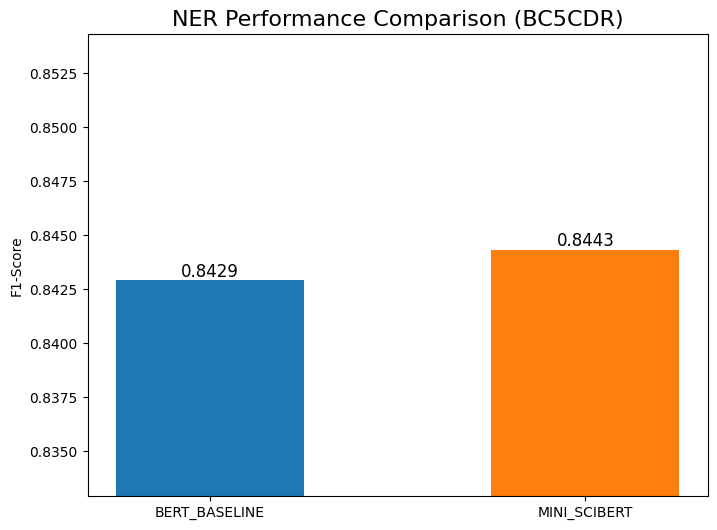

In [ ]:
import os, requests
from datasets import Dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt


pretrained_path = "/kaggle/working/miniscibert_pretrained"
models_to_eval = {

    "BERT_BASELINE": "bert-base-cased",


    "MINI_SCIBERT": pretrained_path if os.path.exists(pretrained_path) else "bert-base-cased"
}
print("Models to evaluate:", models_to_eval)


from transformers import AutoTokenizer, AutoModelForTokenClassification

data_save_path = "/kaggle/working/bc5cdr_data"
os.makedirs(data_save_path, exist_ok=True)

base_url = "https://raw.githubusercontent.com/allenai/scibert/master/data/ner/bc5cdr"
for split in ["train.txt", "dev.txt", "test.txt"]:
    url = f"{base_url}/{split}"
    local_path = f"{data_save_path}/{split}"
    if not os.path.exists(local_path):
        r = requests.get(url)
        with open(local_path, "wb") as f:
            f.write(r.content)
        print("Downloaded:", split)

bc5cdr_train = f"{data_save_path}/train.txt"
bc5cdr_dev   = f"{data_save_path}/dev.txt"
bc5cdr_test  = f"{data_save_path}/test.txt"


def load_bc5cdr(path):
    """Parse CoNLL-style BC5CDR NER data into HF dataset format"""
    sentences, labels = [], []
    cur_sent, cur_labels = [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if cur_sent:
                    sentences.append(cur_sent)
                    labels.append(cur_labels)
                    cur_sent, cur_labels = [], []
                continue
            parts = line.split()
            word, ner = parts[0], parts[-1]
            cur_sent.append(word)
            cur_labels.append(ner)
    if cur_sent:
        sentences.append(cur_sent)
        labels.append(cur_labels)
    return {"words": sentences, "ner_tags": labels}


train_data = load_bc5cdr(bc5cdr_train)
dev_data   = load_bc5cdr(bc5cdr_dev)
test_data  = load_bc5cdr(bc5cdr_test)


unique_labels = sorted(set(tag for seq in train_data["ner_tags"] for tag in seq))
label2id = {l: i for i, l in enumerate(unique_labels)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(unique_labels)

def encode_labels(examples):
    return {"labels": [[label2id[tag] for tag in seq] for seq in examples["ner_tags"]]}

train_ds = Dataset.from_dict(train_data).map(encode_labels, batched=True)
dev_ds   = Dataset.from_dict(dev_data).map(encode_labels, batched=True)
test_ds  = Dataset.from_dict(test_data).map(encode_labels, batched=True)

ner_ds = DatasetDict({"train": train_ds, "validation": dev_ds, "test": test_ds})
print("BC5CDR dataset:", ner_ds)


def preprocess_ner(tokenizer, dataset):
    def tokenize_and_align_labels(batch):
        tokenized = tokenizer(batch["words"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128)
        new_labels = []
        for i, labels in enumerate(batch["labels"]):
            word_ids = tokenized.word_ids(batch_index=i)
            aligned = []
            last_word = None
            for idx, word_id in enumerate(word_ids):
                if word_id is None:
                    aligned.append(-100)
                else:
                    if word_id != last_word:
                        aligned.append(labels[word_id])
                    else:
                        aligned.append(-100)
                    last_word = word_id
            new_labels.append(aligned)
        tokenized["labels"] = new_labels
        return tokenized
    return dataset.map(tokenize_and_align_labels, batched=True, remove_columns=dataset.column_names)


seqeval = load_metric("seqeval")

def compute_ner_metrics_for_trainer(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=2)
    true_labels, true_preds = [], []
    for i in range(len(labels)):
        lab, predt = [], []
        for j, label in enumerate(labels[i]):
            if label != -100:
                lab.append(id2label[label])
                predt.append(id2label[preds[i][j]])
        true_labels.append(lab)
        true_preds.append(predt)
    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"]
    }


ft_results_bc5cdr = {}
for name, ckpt in models_to_eval.items():
    print(f"\n==== Fine-tuning NER model on BC5CDR: {name} ====")
    tok = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    model = AutoModelForTokenClassification.from_pretrained(
        ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id
    ).to(device)

    tt = preprocess_ner(tok, ner_ds["train"])
    vv = preprocess_ner(tok, ner_ds["validation"])

    outdir = f"/kaggle/working/{name}_bc5cdr_ner"
    training_args = TrainingArguments(
        output_dir=outdir,
        num_train_epochs=FT_EPOCHS,
        per_device_train_batch_size=FT_BATCH_SIZE,
        per_device_eval_batch_size=FT_BATCH_SIZE,
        learning_rate=FT_LEARNING_RATE,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        load_best_model_at_end=True,
        save_total_limit=2,
        report_to="wandb",
        run_name=f"{name}-finetune-bc5cdr",
        fp16=True if device=="cuda" else False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tt,
        eval_dataset=vv,
        tokenizer=tok,
        compute_metrics=compute_ner_metrics_for_trainer
    )
    trainer.train()
    res = trainer.evaluate()
    print(name, "BC5CDR NER eval:", res)
    ft_results_bc5cdr[name+"_NER"] = res
    trainer.save_model(outdir)
    wandb.log_artifact(outdir, type="model", name=f"{name.lower()}_finetuned_bc5cdr")


print("\n--- FINE-TUNING SUMMARY (NER - BC5CDR) ---")

summary_list = []
for name, result in ft_results_bc5cdr.items():
    summary_list.append({
        "Model": name.replace("_NER", ""),
        "F1-Score": result['eval_f1'],
        "Precision": result['eval_precision'],
        "Recall": result['eval_recall']
    })

summary_df = pd.DataFrame(summary_list)
pd.options.display.float_format = '{:.4f}'.format
print(summary_df.to_string(index=False))

plt.figure(figsize=(8, 6))
bars = plt.bar(summary_df['Model'], summary_df['F1-Score'], color=['#1f77b4', '#ff7f0e'], width=0.5)
plt.title('NER Performance Comparison (BC5CDR)', fontsize=16)
plt.ylabel('F1-Score')

min_score = summary_df['F1-Score'].min()
max_score = summary_df['F1-Score'].max()
plt.ylim(min_score - 0.01, max_score + 0.01)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)

plt.show()




# Fine-tune on SciCite Text Classification Task
Download SciCite dataset and fine-tune both baseline and Mini-SciBERT models for citation intent classification.

Models to evaluate: {'BERT_BASELINE': 'bert-base-cased', 'MINI_SCIBERT': '/kaggle/working/miniscibert_pretrained'}

Train samples: 7320
Dev samples: 916
Labels: ['background', 'method', 'result']


Map:   0%|          | 0/7320 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

Map:   0%|          | 0/1861 [00:00<?, ? examples/s]


SciCite dataset: DatasetDict({
    train: Dataset({
        features: ['sentence', 'labels', 'label'],
        num_rows: 7320
    })
    validation: Dataset({
        features: ['sentence', 'labels', 'label'],
        num_rows: 916
    })
    test: Dataset({
        features: ['sentence', 'labels', 'label'],
        num_rows: 1861
    })
})

==== Fine-tuning TC model on SciCite: BERT_BASELINE ====


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7320 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

/tmp/ipykernel_37/2634768337.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.412900,0.398544,0.852620
2,0.295900,0.401380,0.844978
3,0.237200,0.443157,0.849345
4,0.159200,0.491355,0.849345
5,0.136800,0.524243,0.842795


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

BERT_BASELINE SciCite eval: {'eval_loss': 0.39854395389556885, 'eval_accuracy': 0.8526200873362445, 'eval_runtime': 4.0603, 'eval_samples_per_second': 225.597, 'eval_steps_per_second': 3.694, 'epoch': 5.0}


wandb: Adding directory to artifact (/kaggle/working/BERT_BASELINE_scicite_tc)... Done. 13.4s
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /kaggle/working/miniscibert_pretrained and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==== Fine-tuning TC model on SciCite: MINI_SCIBERT ====


Map:   0%|          | 0/7320 [00:00<?, ? examples/s]

Map:   0%|          | 0/916 [00:00<?, ? examples/s]

/tmp/ipykernel_37/2634768337.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.397700,0.412519,0.838428
2,0.294700,0.405913,0.847162
3,0.240900,0.446500,0.844978
4,0.163800,0.523776,0.847162
5,0.138600,0.550708,0.843886


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

MINI_SCIBERT SciCite eval: {'eval_loss': 0.4059132933616638, 'eval_accuracy': 0.8471615720524017, 'eval_runtime': 4.0955, 'eval_samples_per_second': 223.661, 'eval_steps_per_second': 3.663, 'epoch': 5.0}


wandb: Adding directory to artifact (/kaggle/working/MINI_SCIBERT_scicite_tc)... Done. 18.3s



--- FINE-TUNING SUMMARY (Text Classification - SciCite) ---
        Model  Accuracy   Loss
BERT_BASELINE    0.8526 0.3985
 MINI_SCIBERT    0.8472 0.4059


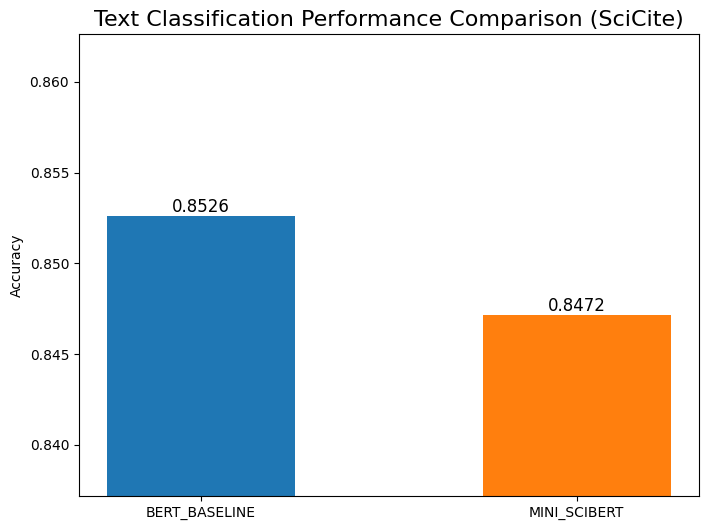

In [ ]:
import os, requests, json
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from evaluate import load as load_metric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pretrained_path = "/kaggle/working/miniscibert_pretrained"
models_to_eval = {
    "BERT_BASELINE": "bert-base-cased",
    "MINI_SCIBERT": pretrained_path if os.path.exists(pretrained_path) else "bert-base-cased"
}
print("Models to evaluate:", models_to_eval)

data_save_path = "/kaggle/working/scicite_data"
os.makedirs(data_save_path, exist_ok=True)


base_url = "https://raw.githubusercontent.com/allenai/scibert/master/data/text_classification/sci-cite"
for split in ["train.txt", "dev.txt", "test.txt"]:
    url = f"{base_url}/{split}"
    local_path = f"{data_save_path}/{split}"
    if not os.path.exists(local_path):
        print(f"Downloading {split} from GitHub...")
        r = requests.get(url)
        r.raise_for_status()
        with open(local_path, "wb") as f:
            f.write(r.content)
        print("Successfully downloaded:", split)


scicite_train = f"{data_save_path}/train.txt"
scicite_dev   = f"{data_save_path}/dev.txt"
scicite_test  = f"{data_save_path}/test.txt"


def load_scicite(path):
    """Load SciCite JSONL format data from .txt files"""
    texts, labels = [], []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                obj = json.loads(line)
                texts.append(obj.get("text", ""))
                labels.append(obj["label"])
    return {"sentence": texts, "labels": labels}


train_data = load_scicite(scicite_train)
dev_data   = load_scicite(scicite_dev)
test_data  = load_scicite(scicite_test)

print(f"\nTrain samples: {len(train_data['sentence'])}")
print(f"Dev samples: {len(dev_data['sentence'])}")


unique_labels = sorted(set(train_data["labels"]))
label2id_tc = {l: i for i, l in enumerate(unique_labels)}
id2label_tc = {i: l for l, i in label2id_tc.items()}
num_tc_labels = len(unique_labels)
print(f"Labels: {unique_labels}")

def encode_labels_tc(examples):
    return {"label": [label2id_tc[l] for l in examples["labels"]]}

train_ds = Dataset.from_dict(train_data).map(encode_labels_tc, batched=True)
dev_ds   = Dataset.from_dict(dev_data).map(encode_labels_tc, batched=True)
test_ds  = Dataset.from_dict(test_data).map(encode_labels_tc, batched=True)

tc_ds = DatasetDict({"train": train_ds, "validation": dev_ds, "test": test_ds})
print("\nSciCite dataset:", tc_ds)


def preprocess_tc(tokenizer, dataset):
    def tok(batch):
        return tokenizer(batch['sentence'], truncation=True, padding="max_length", max_length=128)
    return dataset.map(tok, batched=True, remove_columns=['sentence', 'labels'])


acc_metric = load_metric("accuracy")
def compute_tc_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return acc_metric.compute(predictions=preds, references=p.label_ids)


ft_results_scicite = {}
for name, ckpt in models_to_eval.items():
    print(f"\n==== Fine-tuning TC model on SciCite: {name} ====")
    tok = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        ckpt, num_labels=num_tc_labels, id2label=id2label_tc, label2id=label2id_tc
    ).to(device)

    tt = preprocess_tc(tok, tc_ds["train"])
    vv = preprocess_tc(tok, tc_ds["validation"])

    outdir = f"/kaggle/working/{name}_scicite_tc"
    training_args = TrainingArguments(
        output_dir=outdir,
        num_train_epochs=FT_EPOCHS,
        per_device_train_batch_size=FT_BATCH_SIZE,
        per_device_eval_batch_size=FT_BATCH_SIZE,
        learning_rate=FT_LEARNING_RATE,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=50,
        load_best_model_at_end=True,
        report_to="wandb",
        save_total_limit=2,
        run_name=f"{name}-finetune-scicite",
        fp16=True if device=="cuda" else False,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tt,
        eval_dataset=vv,
        tokenizer=tok,
        compute_metrics=compute_tc_metrics
    )
    trainer.train()
    res = trainer.evaluate()
    print(name, "SciCite eval:", res)
    ft_results_scicite[name+"_TC"] = res
    trainer.save_model(outdir)
    wandb.log_artifact(outdir, type="model", name=f"{name.lower()}_finetuned_scicite")



print("\n--- FINE-TUNING SUMMARY (Text Classification - SciCite) ---")

summary_list_tc = []
for name, result in ft_results_scicite.items():
    summary_list_tc.append({
        "Model": name.replace("_TC", ""),
        "Accuracy": result['eval_accuracy'],
        "Loss": result['eval_loss']
    })

summary_df_tc = pd.DataFrame(summary_list_tc)
pd.options.display.float_format = '{:.4f}'.format
print(summary_df_tc.to_string(index=False))

plt.figure(figsize=(8, 6))
bars = plt.bar(summary_df_tc['Model'], summary_df_tc['Accuracy'], color=['#1f77b4', '#ff7f0e'], width=0.5)
plt.title('Text Classification Performance Comparison (SciCite)', fontsize=16)
plt.ylabel('Accuracy')

min_score_tc = summary_df_tc['Accuracy'].min()
max_score_tc = summary_df_tc['Accuracy'].max()
plt.ylim(min_score_tc - 0.01, max_score_tc + 0.01)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)

plt.show()


# Compare Model Performance
Aggregate and visualize the performance comparison between BERT baseline and Mini-SciBERT across both tasks.

--- FINAL PERFORMANCE SUMMARY ---
                         Task   Metric  BERT_BASELINE  MINI_SCIBERT  Difference
                 NER (BC5CDR) F1-Score         0.8429        0.8443      0.0014
Text Classification (SciCite) Accuracy         0.8526        0.8472     -0.0055


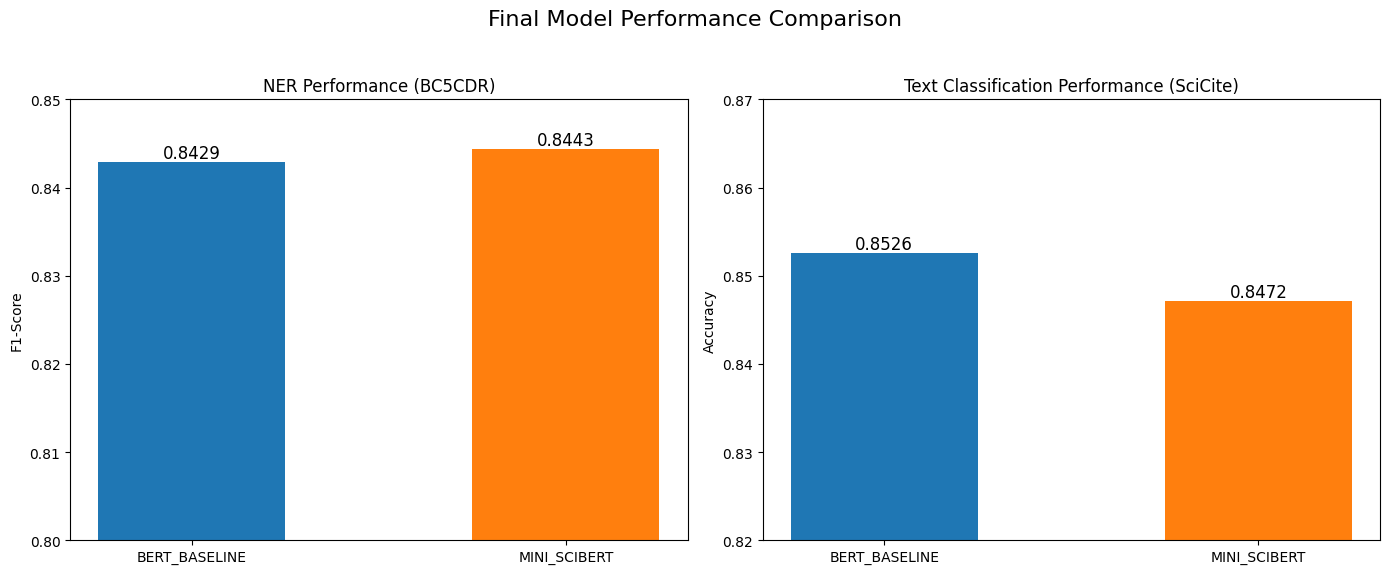

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



ner_baseline_f1 = ft_results_bc5cdr['BERT_BASELINE_NER']['eval_f1']
ner_mini_scibert_f1 = ft_results_bc5cdr['MINI_SCIBERT_NER']['eval_f1']

tc_baseline_acc = ft_results_scicite['BERT_BASELINE_TC']['eval_accuracy']
tc_mini_scibert_acc = ft_results_scicite['MINI_SCIBERT_TC']['eval_accuracy']


summary_data = {
    "Task": ["NER (BC5CDR)", "Text Classification (SciCite)"],
    "Metric": ["F1-Score", "Accuracy"],
    "BERT_BASELINE": [ner_baseline_f1, tc_baseline_acc],
    "MINI_SCIBERT": [ner_mini_scibert_f1, tc_mini_scibert_acc]
}
summary_df = pd.DataFrame(summary_data)
summary_df['Difference'] = summary_df['MINI_SCIBERT'] - summary_df['BERT_BASELINE']

print("--- FINAL PERFORMANCE SUMMARY ---")
pd.options.display.float_format = '{:.4f}'.format
print(summary_df.to_string(index=False))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Final Model Performance Comparison', fontsize=16)


tasks = ['BERT_BASELINE', 'MINI_SCIBERT']
ner_scores = [ner_baseline_f1, ner_mini_scibert_f1]
ax1.bar(tasks, ner_scores, color=['#1f77b4', '#ff7f0e'], width=0.5)
ax1.set_title('NER Performance (BC5CDR)')
ax1.set_ylabel('F1-Score')
ax1.set_ylim(0.80, 0.85)
for i, score in enumerate(ner_scores):
    ax1.text(i, score, f'{score:.4f}', ha='center', va='bottom', fontsize=12)


tc_scores = [tc_baseline_acc, tc_mini_scibert_acc]
ax2.bar(tasks, tc_scores, color=['#1f77b4', '#ff7f0e'], width=0.5)
ax2.set_title('Text Classification Performance (SciCite)')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0.82, 0.87)
for i, score in enumerate(tc_scores):
    ax2.text(i, score, f'{score:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Final Evaluation on Test Sets
Evaluate the fine-tuned Mini-SciBERT model on unseen test data for both NER and text classification tasks.

--- FINAL EVALUATION ON UNSEEN TEST DATA ---

Evaluating NER on BC5CDR test set...


Map:   0%|          | 0/4139 [00:00<?, ? examples/s]

/tmp/ipykernel_37/1100108595.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ner_tester = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Final MINI_SCIBERT NER Performance on Test Set: {'eval_loss': 0.10909847915172577, 'eval_precision': 0.8089128966914247, 'eval_recall': 0.8682957133982191, 'eval_f1': 0.8375530586766541, 'eval_runtime': 25.8632, 'eval_samples_per_second': 160.034, 'eval_steps_per_second': 10.014}

Evaluating Text Classification on SciCite test set...


Map:   0%|          | 0/1861 [00:00<?, ? examples/s]

/tmp/ipykernel_37/1100108595.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  tc_tester = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final MINI_SCIBERT TC Performance on Test Set: {'eval_loss': 0.3783455789089203, 'eval_accuracy': 0.8672756582482536, 'eval_runtime': 11.9165, 'eval_samples_per_second': 156.17, 'eval_steps_per_second': 9.818}

--- FINAL TEST SET PERFORMANCE SUMMARY ---
                         Task   Metric  Final Score (Test Set)
                 NER (BC5CDR) F1-Score                  0.8376
Text Classification (SciCite) Accuracy                  0.8673


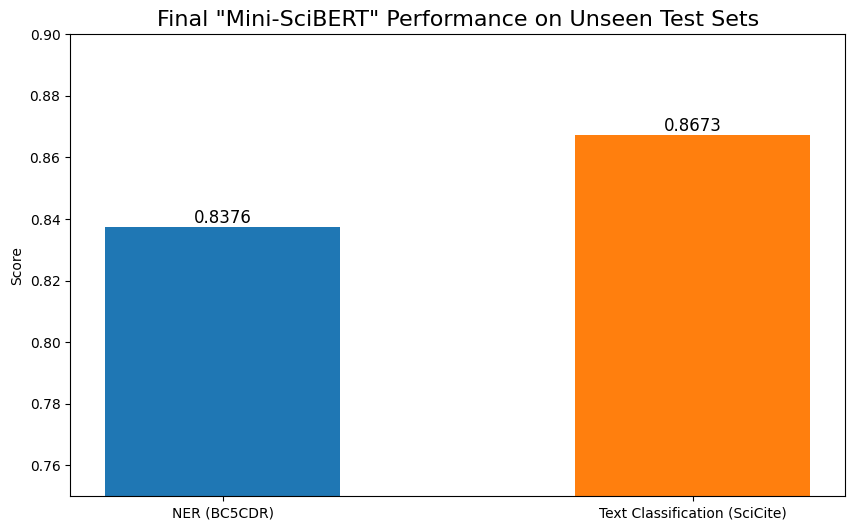

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

print("--- FINAL EVALUATION ON UNSEEN TEST DATA ---")


print("\nEvaluating NER on BC5CDR test set...")
ner_model_path = "/kaggle/working/MINI_SCIBERT_bc5cdr_ner"
ner_tokenizer = AutoTokenizer.from_pretrained(ner_model_path)
ner_model = AutoModelForTokenClassification.from_pretrained(ner_model_path).to(device)
ner_test_tokenized = preprocess_ner(ner_tokenizer, ner_ds["test"])
ner_tester = Trainer(
    model=ner_model,
    tokenizer=ner_tokenizer,
    compute_metrics=compute_ner_metrics_for_trainer
)
ner_test_results = ner_tester.evaluate(eval_dataset=ner_test_tokenized)
print("Final MINI_SCIBERT NER Performance on Test Set:", ner_test_results)



print("\nEvaluating Text Classification on SciCite test set...")
tc_model_path = "/kaggle/working/MINI_SCIBERT_scicite_tc"
tc_tokenizer = AutoTokenizer.from_pretrained(tc_model_path)
tc_model = AutoModelForSequenceClassification.from_pretrained(tc_model_path).to(device)
tc_test_tokenized = preprocess_tc(tc_tokenizer, tc_ds["test"])
tc_tester = Trainer(
    model=tc_model,
    tokenizer=tc_tokenizer,
    compute_metrics=compute_tc_metrics
)
tc_test_results = tc_tester.evaluate(eval_dataset=tc_test_tokenized)
print("Final MINI_SCIBERT TC Performance on Test Set:", tc_test_results)



print("\n--- FINAL TEST SET PERFORMANCE SUMMARY ---")


final_ner_f1 = ner_test_results.get('eval_f1', 0)
final_tc_acc = tc_test_results.get('eval_accuracy', 0)


summary_data = {
    "Task": ["NER (BC5CDR)", "Text Classification (SciCite)"],
    "Metric": ["F1-Score", "Accuracy"],
    "Final Score (Test Set)": [final_ner_f1, final_tc_acc]
}
summary_df = pd.DataFrame(summary_data)
pd.options.display.float_format = '{:.4f}'.format
print(summary_df.to_string(index=False))


plt.figure(figsize=(10, 6))
bars = plt.bar(summary_df['Task'], summary_df['Final Score (Test Set)'], color=['#1f77b4', '#ff7f0e'], width=0.5)
plt.title('Final "Mini-SciBERT" Performance on Unseen Test Sets', fontsize=16)
plt.ylabel('Score')
plt.ylim(0.75, 0.90)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)

plt.show()
